# WSmart+ Route Output

In [2]:
from notebook_setup import setup_home_directory, setup_google_colab


NOTEBOOK_NAME = 'output'
home_dir = setup_home_directory(NOTEBOOK_NAME)
IN_COLAB, gdrive, gfiles = setup_google_colab(NOTEBOOK_NAME)

Setup completed - added home_dir to system path: /home/pkhunter/Repositories/wsmart_route


In [3]:
if IN_COLAB:
    %pip install pandas
    %pip install numpy
    %pip install matplotlib

In [4]:
import os
import sys
import json
import itertools
import traceback
import numpy as np
import pandas as pd

%matplotlib inline
from utils.definitions import SIM_METRICS
from matplotlib import pyplot as plt
from pipeline.simulator.processor import sort_dataframe
from utils.plot_utils import plot_linechart
from utils.io_utils import read_json, read_output
from utils.log_utils import load_log_dict, update_log, output_stats, runs_per_policy, compose_dirpath


PROCESS_OUTPUT = False
COMBINE_OUTPUT = False
if IN_COLAB:
    gdrive.mount('/content/drive')

# Required to use matplotlib in Windows without breaking the Kernel
if os.name == 'nt':
    os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

ndays = 31
n_bins = [20, 50, 100, 170]
n_samples = [10] * len(n_bins)
problem = 'wcrp'
area = "Rio Maior"
source = area.translate(str.maketrans('', '', '-_ ')).lower()
output_logs = load_log_dict(home_dir, ndays, nbins=n_bins, output_dir="output", nsamples=n_samples, area=source)

data_dir = os.path.join(home_dir, "data", "wsr_simulator")
output_dir = os.path.join(home_dir, "assets", "output", f"{ndays}_days", "analytics")
try:
    os.makedirs(data_dir, exist_ok=True)
    os.makedirs(output_dir, exist_ok=True)
except Exception:
    traceback.print_exc(file=sys.stdout)

In [5]:
@compose_dirpath
def combine_output_files(dir_path, src_file, dst_file, policies, start_id=0, delete_src=False):
    dir_path = dir_path[0]
    assert src_file != "" and dst_file != ""
    src_filepath = os.path.join(dir_path, src_file)
    dst_filepath = os.path.join(dir_path, dst_file)
    src_data = read_json(src_filepath)
    total_data = update_log(dst_filepath, src_data, start_id, policies)
    if delete_src:
        os.remove(src_filepath)
    return total_data


def compute_stats(home_dir, ndays, out_dir, nbins, nsamples, policies, keys, area):
    assert len(nbins) == len(nsamples), f"Len of nbins and nsamples lists must be equal, not {len(nbins)} != {len(nsamples)}"
    log_ls = []
    log_std_ls = []
    for gs, ns in zip(nbins, nsamples):
        log, log_std = output_stats(home_dir, ndays, gs, out_dir, area, ns, policies, keys, print_output=True)
        log_ls.append(log)
        log_std_ls.append(log_std)
    return log_ls, log_std_ls


def get_results(logs, nsamples_ls, policies, out_path, distribution, area="riomaior"):
    log = []
    log_std = []
    full_daily_log = []
    dist_policies = ["{}_{}".format(pol, distribution) for pol in policies]
    for n_bins, Nsamples in zip(logs.keys(), nsamples_ls):
        mean_path = os.path.join(os.path.dirname(out_path), f"{area}_{n_bins}", f'log_mean_{Nsamples}N.json')
        tmp = read_output(mean_path, dist_policies)
        log.append(tmp)
        if Nsamples > 1:
            std_path = os.path.join(os.path.dirname(out_path), f"{area}_{n_bins}", f'log_std_{Nsamples}N.json')
            tmp_std = read_output(std_path, dist_policies)
            log_std.append(tmp_std)
        else:
            log_std.append([0] * len(tmp))
        daily_path = os.path.join(os.path.dirname(out_path), f"{area}_{n_bins}", f'daily_{distribution}_{Nsamples}N.json')
        tmp = read_json(daily_path)
        full_daily_log.append(tmp)
    return log, log_std, full_daily_log, dist_policies


def get_display_logs(logs, policies, distributions, n_samples, out_path, area="riomaior"):
    dist_mlogs = []
    dist_slogs = []
    daily_logs = []
    plot_policies = []
    display_logs = {}
    for dist in distributions:
        mean_log, std_log, full_daily_log, dist_policies = get_results(logs, n_samples, policies, out_path, dist, area)
        plot_policies.append(dist_policies)
        dist_mlogs.append(np.array(mean_log))
        dist_slogs.append(np.array(std_log))
        daily_logs.append(full_daily_log)
        display_logs[dist] = np.moveaxis(dist_mlogs[-1], [0, 1, 2], [0, 2, 1])
        print(f"{dist} log shape: {dist_mlogs[-1].shape} -> {display_logs[dist].shape}")
    return np.array(dist_mlogs), np.array(dist_slogs), display_logs, plot_policies, daily_logs

## Output processing

In [6]:
display_dists = ["emp"]
display_policies = ['am', 'policy_last_minute50', 'policy_regular3', 
                    'policy_look_ahead_a', 'policy_look_ahead_a_sans', 'policy_look_ahead_a_vrpp', 
                    'gurobi_vrpp0.84', 'hexaly_vrpp0.84'] 
# 'am', 'amgc', 'transgcn', 'policy_last_minute50', 'policy_last_minute_and_path50', 'policy_regular3', 'gurobi0.84', 'policy_look_ahead_a']
all_policies = [x + '_' + y for x, y in itertools.product(display_policies, display_dists)]

In [7]:
if PROCESS_OUTPUT:
    rpp = runs_per_policy(home_dir, ndays, nbins=n_bins, output_dir="output", nsamples=n_samples, policies=all_policies, print_output=True, area=source)

In [8]:
if False:
    path = "assets/output/31_days/riomaior_120/log_full_10N.json"
    full_out = read_json(os.path.join(home_dir, path))
    comp_keys = list(full_out[0].keys())
    log, log_std = output_stats(home_dir, ndays, n_bins, "output", source, nsamples=n_samples, policies=comp_keys, keys=SIM_METRICS)
    print(json.dumps(log, indent=True))
    print(json.dumps(log_std, indent=True))

In [9]:
if False:
    lg_ls = []
    policy_tmp = 'gurobi1.68_gamma3'
    for sample_log in full_out:
        for key, val in sample_log.items():
            if key == policy_tmp: lg_ls.append(val)

    df = pd.DataFrame(lg_ls)
    sums = df.sum().to_dict()
    df_tmp = {
        "overflows": 13.9,
        "kg": 49709.10959383026,
        "ncol": 1672.6,
        "kg_lost": 137.2963686698182,
        "km": 3243.1200000000003,
        "days": 18.6,
        "kg/km": 15.339864036880927,
        "time": 11618.062866528413
    }
    res = {key: df_tmp[key]*10 - sums[key] for key in df_tmp.keys()}
    res

In [10]:
if PROCESS_OUTPUT:
    log, log_std = compute_stats(home_dir, ndays, nbins=n_bins, out_dir="output", area=source, nsamples=n_samples, policies=[], keys=SIM_METRICS)

In [11]:
if COMBINE_OUTPUT:
    src_file = "log_full_10N2.json"
    dst_file = "log_full_10N.json"
    combine_output_files(home_dir, ndays, [120], "output", source, src_file, dst_file, policies=['gurobi1.68_gamma1', 'gurobi1.68_gamma2'])

## Results comparison

In [12]:
pds_ls = []
name = "comp"
dist_mlogs, dist_slogs, display_logs, plot_policies, daily_logs = get_display_logs(output_logs, display_policies, display_dists, n_samples, output_dir)

emp log shape: (4, 9, 8) -> (4, 8, 9)


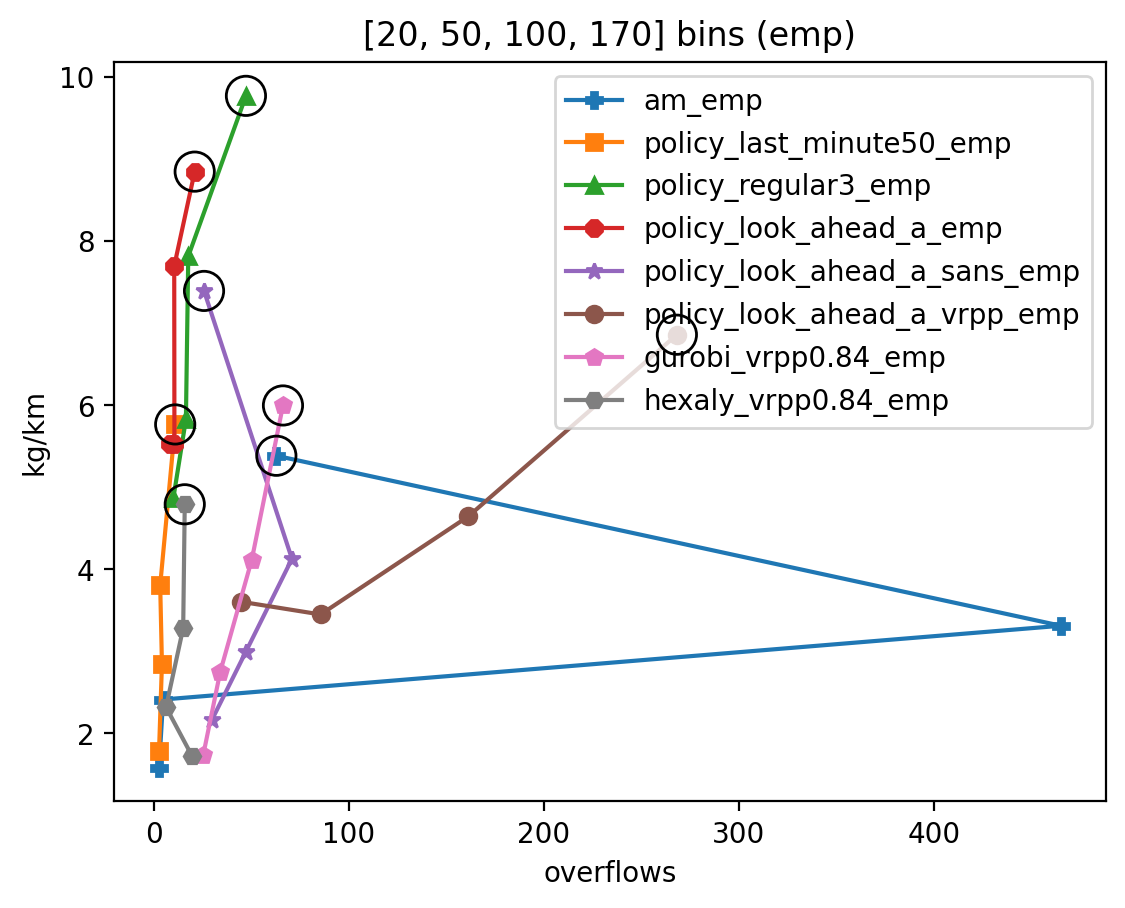

In [13]:
scale = "linear"
if True:
    for id, (dist, dist_log) in enumerate(display_logs.items()):
        x_label = 'overflows'
        y_label = 'kg/km'
        description = f"{n_bins} bins ({dist})"
        if scale != "linear":
            output_path = os.path.join(output_dir, f"{scale}_{name}{n_bins}_{dist}.png")
        else:
            output_path = os.path.join(output_dir, f"{name}{n_bins}_{dist}.png")

        # Dashed black line na fronteira pareto
        markers = ['P', 's', '^', '8', '*', 'o', 'p', 'H']
        #linestyles = ['dotted', 'dashed', 'dashdot', (0, (3, 5, 1, 5, 1, 5))] #, 'solid']
        plot_func = lambda l1, l2, l3, l4, marker: plt.plot([l1[0], l2[0], l3[0], l4[0]], [l1[5], l2[5], l3[5], l4[5]], marker=marker)
        pds = plot_linechart(output_path, dist_log, plot_func, plot_policies[id], x_label, y_label, description, 
                            annotate=True, pareto_front=False, scale=scale, linestyles=None, markers=markers)
        pds_ls.append(pds)
        if IN_COLAB:
            gfiles.download(output_path)

In [14]:
from pipeline.simulator.processor import process_data, process_coordinates
from pipeline.simulator.loader import load_depot, load_simulator_data, load_indices

tour_nbins = n_bins[0]
tour_wtype = 'plastic'
depot = load_depot(data_dir, area.translate(str.maketrans('', '', '-_ ')).lower())
data, bins_coordinates = load_simulator_data(data_dir, tour_nbins, area.translate(str.maketrans('', '', '-_ ')).lower(), tour_wtype)

tour_nsamples = 1
idx_filename = f"graphs_{tour_nbins}V_1N_{tour_wtype}.json"
indices_ls = load_indices(idx_filename, tour_nsamples, tour_nbins, bins_coordinates.shape[0])
_, coordinates = process_data(data, bins_coordinates, depot, indices=indices_ls[0])

method = "mmn"
depot, loc = process_coordinates(coordinates, method)
tour_xy = np.concatenate([depot.reshape(1, -1), loc], axis=0)

In [15]:
daily_logs[-1][-1].keys()

dict_keys(['am #0', 'am #1', 'am #2', 'am #3', 'am #4', 'am #5', 'am #6', 'am #7', 'am #8', 'am #9', 'policy_last_minute50 #7', 'policy_last_minute50 #8', 'policy_last_minute_and_path50 #1', 'policy_last_minute_and_path50 #3', 'policy_last_minute_and_path50 #4', 'policy_last_minute_and_path50 #5', 'policy_last_minute_and_path50 #6', 'policy_last_minute_and_path50 #8', 'policy_regular3 #0', 'policy_regular3 #1', 'policy_regular3 #2', 'policy_regular3 #3', 'policy_regular3 #4', 'policy_regular3 #5', 'policy_regular3 #6', 'policy_regular3 #7', 'policy_regular3 #8', 'policy_regular3 #9', 'policy_look_ahead_a #0', 'policy_look_ahead_a #1', 'policy_look_ahead_a #2', 'policy_look_ahead_a #3', 'policy_look_ahead_a #4', 'policy_look_ahead_a #5', 'policy_look_ahead_a #6', 'policy_look_ahead_a #7', 'policy_look_ahead_a #8', 'policy_look_ahead_a #9', 'policy_look_ahead_a_sans #0', 'policy_look_ahead_a_sans #1', 'policy_look_ahead_a_sans #2', 'policy_look_ahead_a_sans #3', 'policy_look_ahead_a_sans

In [16]:
dkey = 'policy_look_ahead_a #0'
dlog = daily_logs[-1][-1][dkey]
df = pd.DataFrame(dlog)
df.to_excel(f"{dkey}.xlsx".replace(' ', '_'), index=False)

In [ ]:
dkey = 'hexaly_vrpp0.84 #0'
dlog = daily_logs[-1][-1][dkey]
df = pd.DataFrame(dlog)
df.to_excel(f"{dkey}.xlsx".replace(' ', '_'), index=False)

In [31]:
dkey = 'gurobi_vrpp0.84 #0'
dlog = daily_logs[-1][-1][dkey]
df = pd.DataFrame(dlog)
df.to_excel(f"{dkey}.xlsx".replace(' ', '_'), index=False)

In [34]:
tour = dlog['tour'][0]
id_index = pd.Index(coordinates['ID'])
positions = id_index.get_indexer(tour)

In [35]:
df = pd.DataFrame(dlog)
df.to_excel("output.xlsx", index=False)

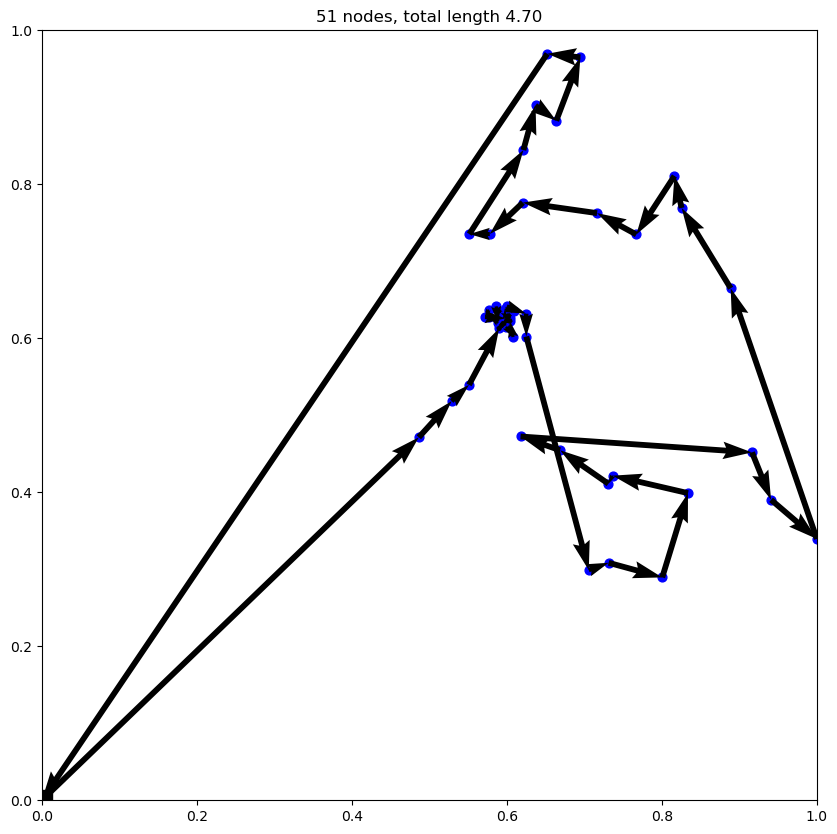

In [37]:
from utils.plot_utils import plot_tsp


tour = daily_logs[0][0]['gurobi0.42 #0']['tour'][0]
id_index = pd.Index(coordinates['ID'])
positions = id_index.get_indexer(tour)
fig, ax = plt.subplots(figsize=(10, 10))
plot_tsp(tour_xy, positions, ax)

In [ ]:
policies = ['attention_model1', \
            'policy_last_minute_and_path50', \
            'policy_regular3', \
            'gurobi']

desc_suffix = "20 ---> 317 bins"
log, log_std, daily_logs, _ = get_results(output_logs, n_samples, policies, output_dir, display_dists)

log = np.moveaxis(log, [0, 1, 2], [2, 0, 1])
log2 = np.swapaxes(log, 0, 2)
print(log.shape)
print(log2.shape)

In [ ]:
scale = "linear"
#desc_suffix="20 bins"
if scale != "linear":
    output_path = os.path.join(output_dir, f"{scale}_comp.png")
else:
    output_path = os.path.join(output_dir, "comp.png")

#linestyles = ['-', '--', '-.', ':']
out_func = lambda l1: plt.plot([l1[0]], [l1[6]], '*-')
#out_func = lambda l1, l2, l3, l4, l5, l6, ls: plt.plot([l1[0], l2[0], l3[0], l4[0], l5[0], l6[0]], [l1[6], l2[6], l3[6], l4[6], l5[6], l6[6]], '*', linestyle=ls)
plot_linechart(output_path, log2, out_func, policies, 'overflows', 'kg/km', f"Comparison: {desc_suffix}", annotate=False, scale=scale, linestyles=None)
if IN_COLAB:
    gfiles.download(output_path)

In [ ]:
x_values = [int(x[2:].strip()) for x in output_logs.keys()]
for metric, nested in zip(SIM_METRICS, log):
    if metric == "kg/km":
        filename = "kgperkm.png"
    else:
        filename = metric

    if scale != "linear":
        output_path = os.path.join(output_dir, f"{scale}_{filename}")
    else:
        output_path = os.path.join(output_dir, filename)

    #out_func = lambda x, y, label: plt.plot(x, y, 'o-', label=label)
    out_func = lambda x, y, label, ls: plt.plot(x, y, 'o', label=label, linestyle=ls)
    plot_linechart(output_path, [nested, policies], out_func, policies, title=metric, x_ls=x_values, x_label='number of bins', y_label=metric, scale=scale, linestyles=linestyles)
    if IN_COLAB:
        gfiles.download(output_path)

## Results for each graph

In [ ]:
df_ls = []
for path in output_logs.values():
    output_dic = read_json(path)
    df = pd.DataFrame.from_dict(output_dic).T
    df_ls.append(df)
    
print(len(df_ls))

In [ ]:
metric_tosort = 'overflows'
for graph_size, df in zip(x_values, df_ls):
    print(f"Number of bins: {graph_size}")
    display(sort_dataframe(df, metric_tosort, ascending_order=True))

In [ ]:
output_dic2 = read_json(wsba_logs['op317'])
wsba_df = pd.DataFrame.from_dict(output_dic2[0]).T
print("Number of bins: 317")
display(sort_dataframe(wsba_df, metric_tosort='overflows', ascending_order=True))

In [ ]:
for graph_size, graph_log in zip(x_values, log2):
    title = f"Number of bins: {graph_size}"
    output_path = os.path.join(output_dir, f"summary_{graph_size}.png")
    out_func = lambda ll: plt.semilogy(['overflows','ncol','days','kgperkm'], ll[[0,2,5,6]], 'o-')
    plot_linechart(output_path, graph_log, out_func, policies, title=title)
    if IN_COLAB:
        gfiles.download(output_path)
    output_path = os.path.join(output_dir, f"full_{graph_size}.png")
    out_func = lambda ll: plt.semilogy(['overflows','kg','ncol','kg_lost','km','days','kgperkm','time'], ll)
    plot_linechart(output_path, graph_log, out_func, policies, title=title)
    if IN_COLAB:
        gfiles.download(output_path)
    output_path = os.path.join(output_dir, f"comp_{graph_size}.png")
    out_func = lambda ll: plt.plot(ll[0],ll[6],'+')
    plot_linechart(output_path, graph_log, out_func, policies, 'overflows', 'kgperkm', title)
    if IN_COLAB:
        gfiles.download(output_path)